# PHASE 3 PROJECT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score

%matplotlib inline

### Data Cleaning

In [2]:
data = pd.read_csv('data/data.csv')

In [3]:
# Dropping columns we are not going to use

df = data.drop('phone number', axis=1)

In [4]:
# Making Yes and No into 0 and 1

df['international plan'] = df['international plan'].map(dict(yes=1, no=0))
df['voice mail plan'] = df['voice mail plan'].map(dict(yes=1, no=0))

In [5]:
# Making sure each columns is the data type it is supposed to be

df['area code'] = df['area code'].astype(object)

In [6]:
# Making 3 different data sets to isolate minutes called, number of calls, total charge

df_minutes = df.drop(['total day calls', 'total day charge', 'total eve calls', 'total eve charge', 'total night calls',
                      'total night charge', 'total intl calls', 'total intl charge'], axis=1)
df_calls = df.drop(['total day minutes', 'total day charge', 'total eve minutes', 'total eve charge',
                   'total night minutes', 'total night charge','total intl minutes', 'total intl charge'], axis=1)
df_charge = df.drop(['total day calls', 'total day minutes', 'total eve calls', 'total eve minutes',
                    'total night calls', 'total night minutes', 'total intl calls', 'total intl minutes'], axis=1)

In [7]:
df_calls.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day calls,total eve calls,total night calls,total intl calls,customer service calls,churn
0,KS,128,415,0,1,25,110,99,91,3,1,False
1,OH,107,415,0,1,26,123,103,103,3,1,False
2,NJ,137,415,0,0,0,114,110,104,5,0,False
3,OH,84,408,1,0,0,71,88,89,7,2,False
4,OK,75,415,1,0,0,113,122,121,3,3,False


### Data Visualization

<AxesSubplot:>

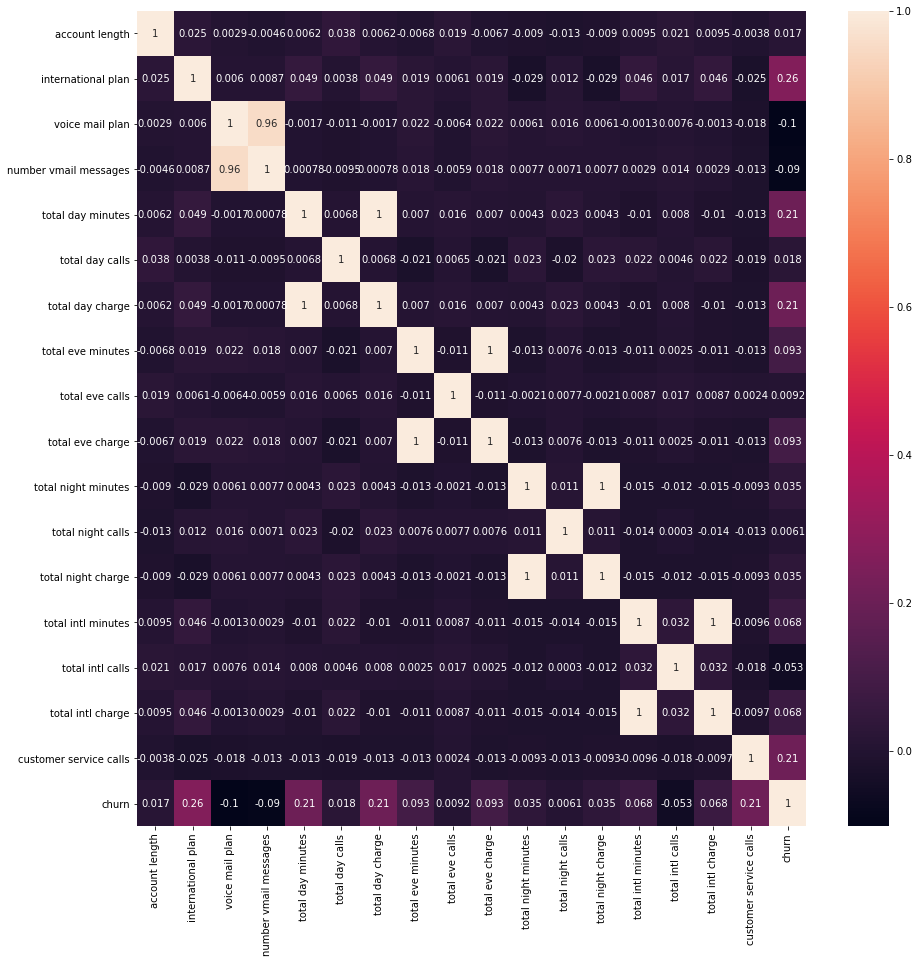

In [8]:
# Our target is churn rate, there is no strong correlation with any other variable, this is good news for any linear regression
# we plan on doing

plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot = True)

### Dummy Model

In [9]:
# We see that we have a 85.5% success rate if we predict false all the time

df['churn'].value_counts(normalize=True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

### Pipeline

In [10]:
# Get list of numerical and object columns

num_cols = df.select_dtypes(include=['float', 'int']).columns.tolist()
obj_cols = df.select_dtypes(include=['object']).columns.tolist()

In [11]:
# Create a ColumnTransformer to handle numerical and object columns separately

preprocessor = ColumnTransformer(
    transformers=[
        ('ss', StandardScaler(), num_cols),
        ('ohe', OneHotEncoder(), obj_cols)
    ]
)

### Train / Test data

In [12]:
# Split the data into features and labels

X = df.drop('churn', axis=1)
y = df['churn']

In [13]:
# Split the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Transform the train and test data

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

### Create ML Models

In [15]:
# Initialize the models

log_reg = LogisticRegression()
random_forest = RandomForestClassifier()
decision_tree = DecisionTreeClassifier()
knn = KNeighborsClassifier()

In [16]:
log_reg.fit(X_train_transformed, y_train)

LogisticRegression()

In [17]:
random_forest.fit(X_train_transformed, y_train)

RandomForestClassifier()

In [18]:
decision_tree.fit(X_train_transformed, y_train)

DecisionTreeClassifier()

In [19]:
knn.fit(X_train_transformed, y_train)

KNeighborsClassifier()

In [20]:
# Evaluate the models on the test data
print('Logistic Regression: ', log_reg.score(X_test_transformed, y_test))
print('Random Forest: ', random_forest.score(X_test_transformed, y_test))
print('Decision Tree: ', decision_tree.score(X_test_transformed, y_test))
print('K-Nearest Neighbors: ', knn.score(X_test_transformed, y_test))

Logistic Regression:  0.8530734632683659
Random Forest:  0.881559220389805
Decision Tree:  0.823088455772114
K-Nearest Neighbors:  0.8740629685157422


### Confusion Matrix

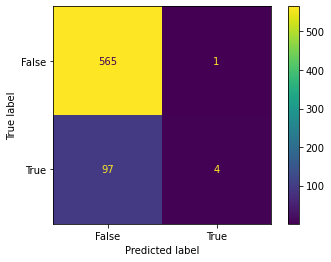

In [21]:
plot_confusion_matrix(log_reg, X_test_transformed, y_test)

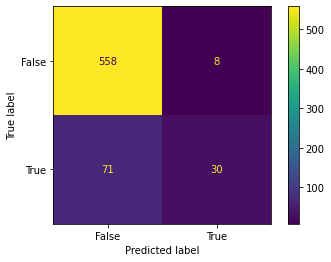

In [22]:
plot_confusion_matrix(random_forest, X_test_transformed, y_test)

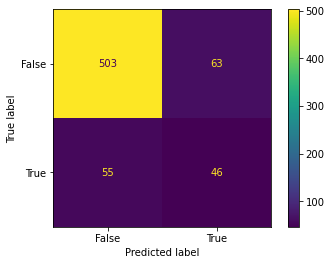

In [23]:
plot_confusion_matrix(decision_tree, X_test_transformed, y_test)

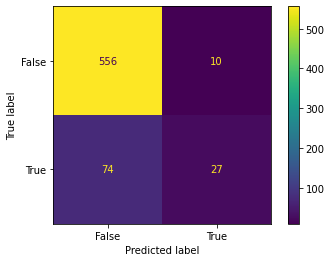

In [24]:
plot_confusion_matrix(knn, X_test_transformed, y_test)

### Gridsearch CV for Random Forest

I am going to use "Random Forest" since it was the better performing model out of the 4.

In [37]:
# Specify the hyperparameters to tune

parameters = {'n_estimators': [10, 50, 100, 200],
              'criterion': ['gini', 'entropy'],
              'max_depth': [None, 5, 10], 
              'max_features': ['auto', 'sqrt']}

In [38]:
grid_search = GridSearchCV(random_forest, parameters, cv=5)
grid_search.fit(X=X_train_transformed, y=y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [10, 50, 100, 200]})

In [39]:
# Print the best set of hyperparameters

print("Best set of hyperparameters:", grid_search.best_params_)

Best set of hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}


In [40]:
print("Best score for tuned hyperparameters: ", grid_search.best_score_)

Best score for tuned hyperparameters:  0.8829710985096021


In [41]:
tuned_random_forest = RandomForestClassifier(criterion='entropy', n_estimators=200)

In [42]:
tuned_random_forest.fit(X_train_transformed, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200)

In [43]:
tuned_random_forest.score(X_test_transformed, y_test)

0.8830584707646177

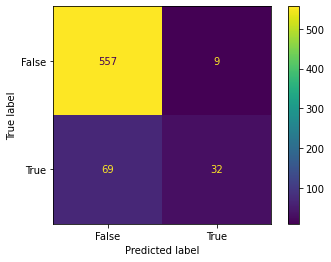

In [44]:
plot_confusion_matrix(tuned_random_forest, X_test_transformed, y_test)

# --- Visualization ---

In [36]:
df.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
